In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((523, 12, 1), (523,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 214ms/step - loss: 0.6542 - root_mean_squared_error: 0.8088 - val_loss: 0.4440 - val_root_mean_squared_error: 0.6663
Epoch 2/50
53/53 [==============================] - 10s 192ms/step - loss: 0.3413 - root_mean_squared_error: 0.5842 - val_loss: 0.0953 - val_root_mean_squared_error: 0.3087
Epoch 3/50
53/53 [==============================] - 10s 192ms/step - loss: 0.0682 - root_mean_squared_error: 0.2611 - val_loss: 0.0937 - val_root_mean_squared_error: 0.3061
Epoch 4/50
53/53 [==============================] - 11s 206ms/step - loss: 0.0635 - root_mean_squared_error: 0.2520 - val_loss: 0.0926 - val_root_mean_squared_error: 0.3044
Epoch 5/50
53/53 [==============================] - 10s 199ms/step - loss: 0.0591 - root_mean_squared_error: 0.2432 - val_loss: 0.0813 - val_root_mean_squared_error: 0.2852
Epoch 6/50
53/53 [==============================] - 10s 194ms/step - loss: 0.0592 - root_mean_squared_error: 0.2433 - val_loss: 0.0761 

53/53 [==============================] - 10s 198ms/step - loss: 0.0364 - root_mean_squared_error: 0.1909 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2137
Epoch 29/50
53/53 [==============================] - 10s 201ms/step - loss: 0.0366 - root_mean_squared_error: 0.1913 - val_loss: 0.0436 - val_root_mean_squared_error: 0.2088
Epoch 30/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0328 - root_mean_squared_error: 0.1810 - val_loss: 0.0444 - val_root_mean_squared_error: 0.2106
Epoch 31/50
53/53 [==============================] - 10s 194ms/step - loss: 0.0328 - root_mean_squared_error: 0.1811 - val_loss: 0.0425 - val_root_mean_squared_error: 0.2061
Epoch 32/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0309 - root_mean_squared_error: 0.1759 - val_loss: 0.0406 - val_root_mean_squared_error: 0.2014
Epoch 33/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0319 - root_mean_squared_error: 0.1786 - val_loss: 0.0420 - val_root

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

6.712516649564107 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

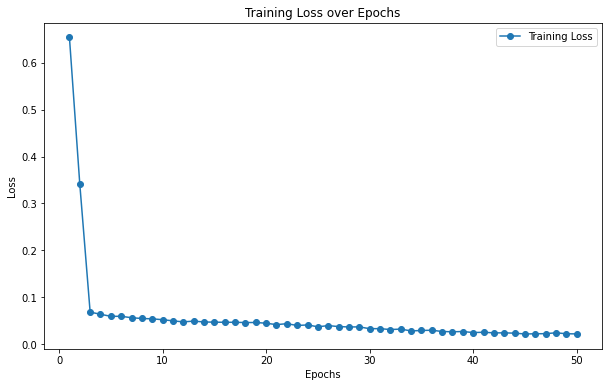

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

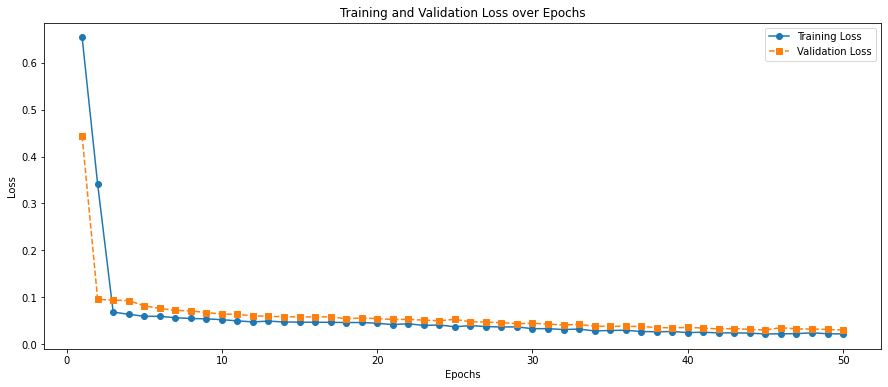

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT4/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.16787669756575502
MAE : 0.1283800510174784


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,311692.750000,71897.386
1,249052.765625,60592.380
2,396390.875000,131973.043
3,606890.812500,753595.099
4,738600.187500,909176.475
5,831833.250000,917006.278
6,883386.250000,906368.363
7,911824.500000,917403.622
8,894410.250000,910653.838
9,826477.375000,822319.125


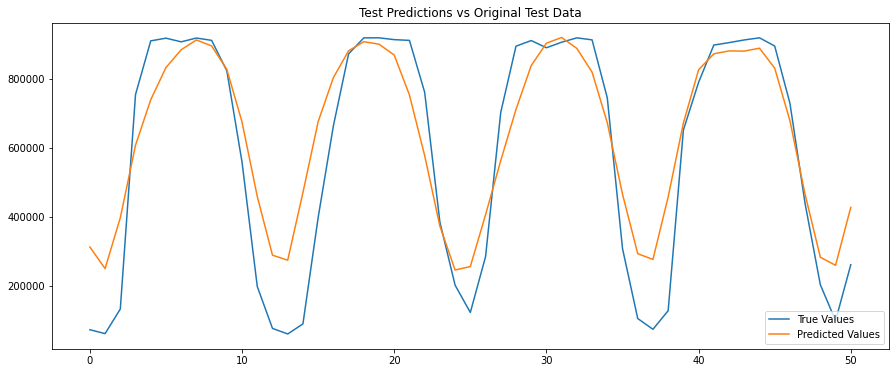

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

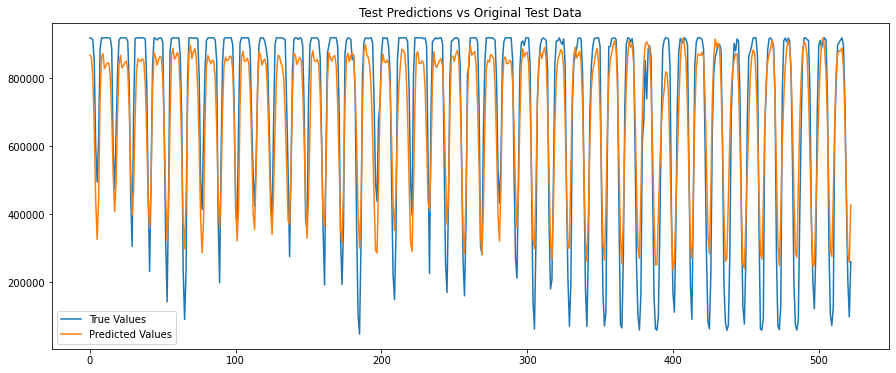

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()